In [20]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.signal import butter, filtfilt
import scipy as sc

In [21]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

#sns.palplot(colors)
plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'y'
#plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [22]:
def read_wave(file_path, resolution=np.int32):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=resolution) 
        signal = signal/np.max(np.abs(signal))
        signal = abs(signal)

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=len(signal))
        

    return signal, sample_rate, time

@numba.njit(fastmath=True)
def peak_finder_neigh(t_list, y_list, neigh=2, threshold=0.1):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1] and y_list[i] > threshold:

            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(t_peak), np.array(peaks)

@numba.njit(fastmath=True)
def signal_avg(signal, time, step):
    new_signal = []
    new_time = time[::step] 

    i = 0
    while i < len(signal):
        if i+10 < len(signal):
            new_signal.append(np.mean(signal[i:i+step]))
            i += step
        else:
            new_signal.append(np.mean(signal[i:]))
            i += step

    return new_time, new_signal

@numba.njit(fastmath=True)
def lin_fit(x, a, b):
    return a*x + b

@numba.njit(fastmath=True)
def p_func(x_list, threshold_l, threshold_h):

    p = np.zeros(len(x_list))

    for i in range(len(x_list)): 
        if i <= threshold_l:
            p[i] = 1
        elif i > threshold_l and i <= threshold_h:
            p[i] = 1/2 * (1 + np.cos(np.pi * (i - threshold_l) / (threshold_h - threshold_l + 1)))
        else:
            p[i] = 0 
        
    return p

@numba.njit(fastmath=True)
def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i

def running_mean(t, s, neigh):
    r_mean_s = []
    r_mean_t = []
    start_i = neigh
    for i in range(len(s) - neigh):
        i_col = i + start_i
        r_mean_s.append(np.mean(s[i:i_col+neigh]))
        r_mean_t.append(t[i_col])
    
    return np.array(r_mean_s), np.array(r_mean_t)

def synchro(cut, met_tuple, exp_tuple):
    ### THIS ASSUMES THAT PARTICIPANTS CLAP AT THE FIRST BEEP OF THE METRONOME ### 

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    s_met = np.array(s_met)
    s_exp = np.array(s_exp)
    t_met = np.array(t_met)
    t_exp = np.array(t_exp)


    min_val_met = min(f_met)
    min_index_met = np.where(f_met == min_val_met)[0][0]

    min_val_exp = min(f_exp)
    min_index_exp = np.where(f_exp == min_val_exp)[0][0]
    
    # Masking peak data of metronome
    mask_met = pt_met >= ft_met[min_index_met]
    mask_exp = pt_exp >= ft_exp[min_index_exp]
    

    first_met_pt = pt_met[mask_met][0]
    first_exp_pt = pt_exp[mask_exp][0]
    mask_met_t = t_met >= first_met_pt
    mask_exp_t = t_exp >= first_exp_pt
    mask_met_f = ft_met > first_met_pt
    mask_exp_f = ft_exp > first_exp_pt

    # Adjusting signal and times
    t_met = t_met[mask_met_t]
    s_met = s_met[mask_met_t]
    t_met = t_met - t_met[0]

    # Adjusting peaks and peak-times
    pt_met = pt_met[mask_met]
    p_met = p_met[mask_met]
    pt_met = pt_met - pt_met[0]


    # Adjusting signal and time
    t_exp = t_exp[mask_exp_t]
    s_exp = s_exp[mask_exp_t]
    t_exp = t_exp - t_exp[0]

    # Adjusting peaks and peak-times
    pt_exp = pt_exp[mask_exp]
    p_exp = p_exp[mask_exp]
    pt_exp = pt_exp - pt_exp[0]


    # Adjusting the frequency data
    f_met = 1/np.diff(pt_met)
    ft_met = pt_met[1:]
    f_exp = 1/np.diff(pt_exp)
    ft_exp = pt_exp[1:]
    

    ## Cutting off a desired number of claps
    #ft_exp = ft_exp[cut:]
    #f_exp = f_exp[cut:]
    #ft_met = ft_met[cut:]
    #f_met = f_met[cut:]

    ## Synchronizing the two signals at the first data point
    #diff = ft_exp[0] - ft_met[0]
    #ft_exp = ft_exp - diff


    re_met_tuple = t_met, s_met, pt_met, p_met, ft_met, f_met
    re_exp_tuple = t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp
    
    return re_met_tuple, re_exp_tuple

def data_extract(file, step=200, neigh=10, threshold=0.1, resolution=np.int32):
    signal, sample_rate, time = read_wave(file, resolution)
    time, signal = signal_avg(signal, time, step)
    peak_times, peaks = peak_finder_neigh(time, signal, neigh, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list

def avg_calc(met_tuple, exp_tuple):

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple 

    # Calculating bin edges for time intervals to take the average of the peak times in
    bin_edges = (pt_met[:-1] + pt_met[1:])/2

    # Add start and end point
    start_diff = bin_edges[1] - bin_edges[0]
    end_diff = bin_edges[-1] - bin_edges[-2]
    bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))


    avg_val = []
    std_val = []
    for i in range(len(bin_edges) - 1):
        mask = (pt_exp > bin_edges[i]) & (pt_exp < bin_edges[i+1])
        masked_data = pt_exp[mask]
        if len(masked_data) > 0:
            avg = np.mean(masked_data)
            std = np.std(masked_data)
            avg_val.append(avg)
            std_val.append(std)

        else:
            print('No data in bin')
            continue

    avg_val = np.array(avg_val)
    avg_per = avg_val[1:] - avg_val[:-1]
    avg_freq = 1/avg_per


    t_err = []
    for i in range(len(std_val)-1):
        t_err_i = np.sqrt(std_val[i]**2 + std_val[i+1]**2)
        t_err.append(t_err_i)

    freq_err = []

    for i in range(len(t_err)): 
        freq_err_i = np.sqrt(1/avg_per[i]**2 * t_err[i]**2)
        freq_err.append(freq_err_i)

    return avg_freq, freq_err, avg_per #, avg_val, avg_std

def final_data(filename1, filename2, step=200, neigh=10, threshold=(0.08, 0.05), resolution=np.int16):
    met_tuple = data_extract(f'lydfiler/metronomfiler/{filename1}.wav', step, neigh, threshold[0], resolution)
    exp_tuple = data_extract(f'lydfiler/{filename2}.wav', step, neigh, threshold[1], resolution)

    met_tuple, exp_tuple = synchro(zero_cut, met_tuple, exp_tuple)
    avg_freq, freq_err, avg_per = avg_calc(met_tuple, exp_tuple)

    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple

    x = np.cumsum(avg_per)

    return avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp 

def smooth_signal(signal, time, cutoff=5, order=3):
    dt = time[-1]/len(time)
    nyquist = 0.5 / dt
    normal_cutoff = cutoff / nyquist

    #print(f"Order: {order}, Type: {type(order)}")

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    smoothed_signal = filtfilt(b, a, signal)
    return smoothed_signal

def new_data_extract(file, resolution, neigh_rm, height_var, prominence_var):
    signal, sample_rate, time = read_wave(file, resolution)
    signal, time = running_mean(time, signal, neigh_rm)
    peak_indicies = sc.signal.find_peaks(signal, height=height_var, prominence=prominence_var)[0]
    peak_times = time[peak_indicies]
    peaks = signal[peak_indicies]

    #peak_times, peaks = peak_finder_neigh(time, signal, neigh_peak, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list

def new_final_data(filename1, filename2, resolution=(np.int16, np.int16), neigh_rm=100, height=0.025, prominence=0.02):
    met_tuple = new_data_extract(f'lydfiler/metronomfiler/{filename1}.wav', resolution[0], neigh_rm, height, prominence)
    exp_tuple = new_data_extract(f'lydfiler/{filename2}.wav', resolution[1], neigh_rm, height, prominence)

    met_tuple, exp_tuple = synchro(zero_cut, met_tuple, exp_tuple)
    avg_freq, freq_err, avg_per = avg_calc(met_tuple, exp_tuple)

    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple

    x = np.cumsum(avg_per)

    return avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp 


In [42]:
read_wave('lydfiler/metronomfiler/low_high.wav', resolution=np.int32)[1]

44100

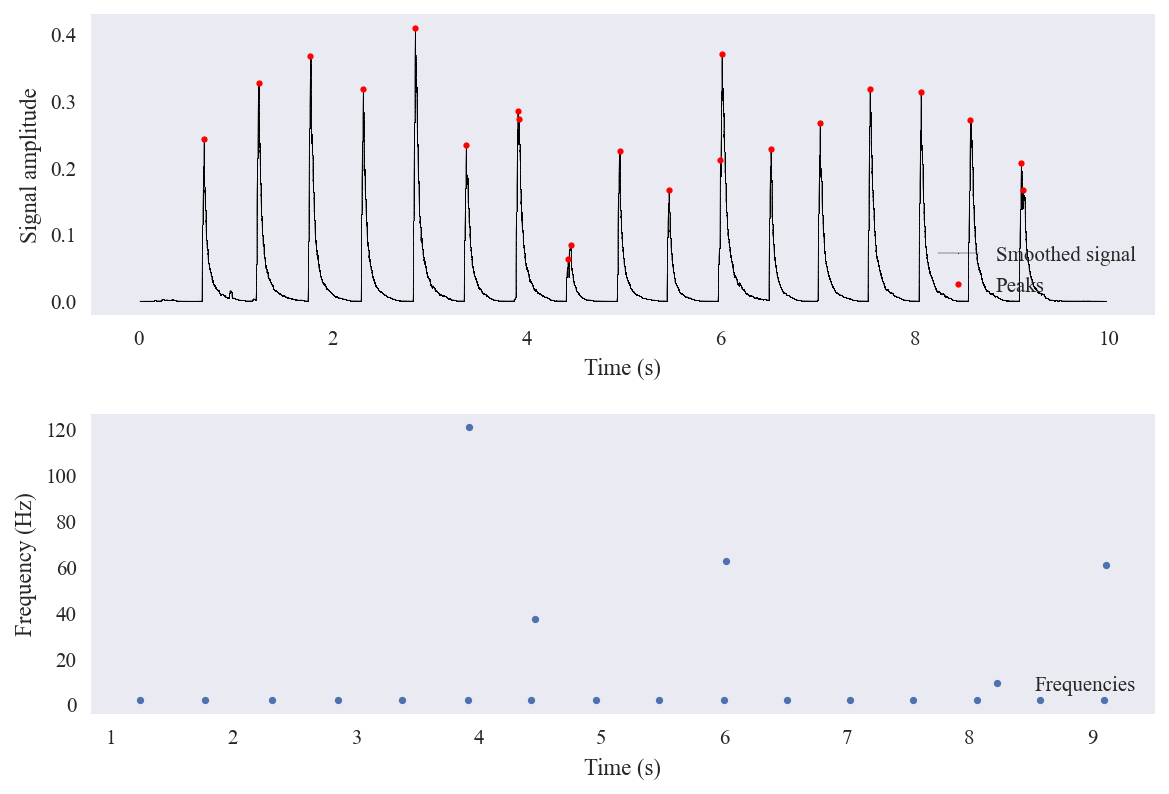

In [44]:
new_time, new_signal, peak_times, peaks, freq_tlist, freq_list = new_data_extract('trial.wav',
                                                                                   resolution=np.int32, 
                                                                                   neigh_rm=500, 
                                                                                   height_var=0.05,
                                                                                   prominence_var=0.02)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time, 
           new_signal, 
           color='black', 
           ls='-', 
           marker='.', 
           linewidth = 0.2, 
           markersize=0.8, 
           label='Smoothed signal')


ax[0].plot(peak_times, peaks, color='red', ls='', marker='o', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')
#ax[0].set_xlim(5.9,6.1)

ax[1].plot(freq_tlist, freq_list, '.', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

Sigrid and Niels clapping to the low mid metronome 

In [36]:
ns_tuple_lm = new_data_extract('lydfiler/metronomfiler/Niels_og_Sigrid.wav', 
                               resolution=np.int32, 
                               neigh_rm=100, 
                               height_var=0.05,
                               prominence_var=0.01)

met_tuple_lm = new_data_extract('lydfiler/metronomfiler/low_mid.wav', 
                                resolution=np.int32, 
                                neigh_rm=100, 
                                height_var=0.05,
                                prominence_var=0.02)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple_lm
t_ns, s_ns, pt_ns, p_ns, ft_ns, f_ns = ns_tuple_lm

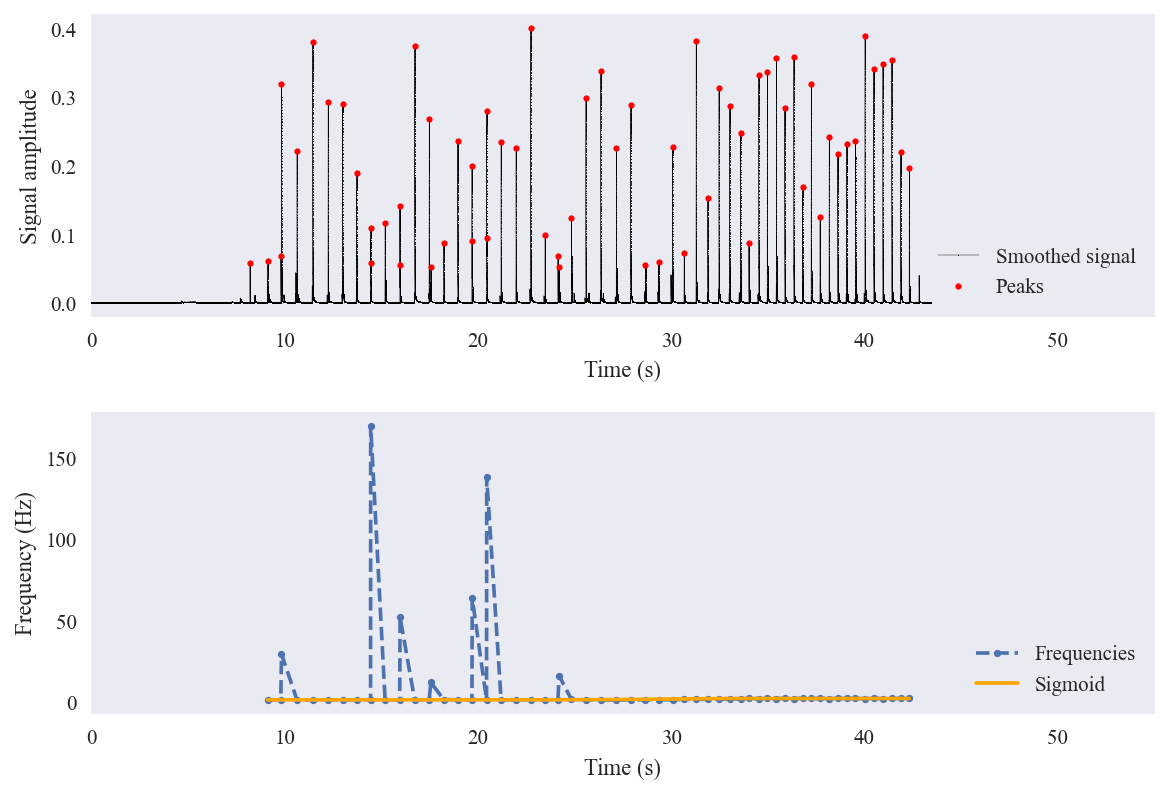

In [37]:
sig_x = np.linspace(9, ft_ns[-1], len(ft_ns))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)


fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(t_ns, s_ns, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(pt_ns, p_ns, color='red', ls='', marker='o', linewidth = 0.2, markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].set_xlim(0,55)
ax[0].legend(loc='lower right')

ax[1].plot(ft_ns, f_ns, '.--', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlim(0,55)
ax[1].plot(ft_ns, sig_y, c='orange', label = 'Sigmoid')
ax[1].legend(loc='lower right')

fig.tight_layout()

Synchronised data for Niels and Sigrid clapping to the low mid metronome

In [26]:
cut = 0
met_tuple_lm, ns_tuple_lm = synchro(0, met_tuple_lm, ns_tuple_lm)

t_met_lm, s_met_lm, pt_met_lm, p_met_lm, ft_met_lm, f_met_lm = met_tuple_lm
t_ns_lm, s_ns_lm, pt_ns_lm, p_ns_lm, ft_ns_lm, f_ns_lm = ns_tuple_lm


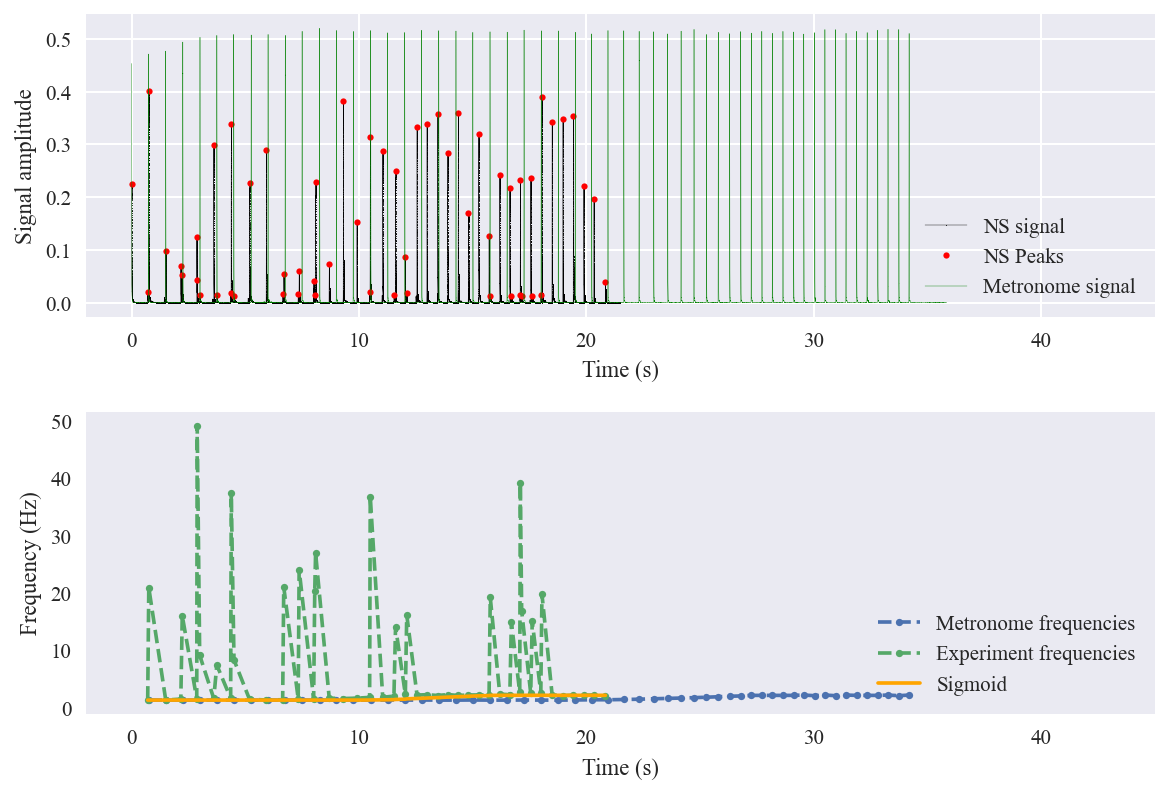

In [27]:
sig_x = np.linspace(0, ft_ns_lm[-1], len(ft_ns_lm))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)

fig, ax = plt.subplots(2,1, dpi=150)

ax[0].plot(t_ns_lm, s_ns_lm, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax[0].plot(pt_ns_lm, p_ns_lm, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
#ax[0]].plot(pt_met_lm, p_met_lm, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax[0].plot(t_met_lm, s_met_lm, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax[0].legend(loc='lower right')
ax[0].set_xlim(-2,45)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')

ax[1].plot(ft_met_lm, f_met_lm, '.--', label='Metronome frequencies')
ax[1].plot(ft_ns_lm, f_ns_lm, '.--', label='Experiment frequencies')
ax[1].plot(ft_ns_lm, sig_y, c='orange', label = 'Sigmoid')
ax[1].set_xlim(-2,45)
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

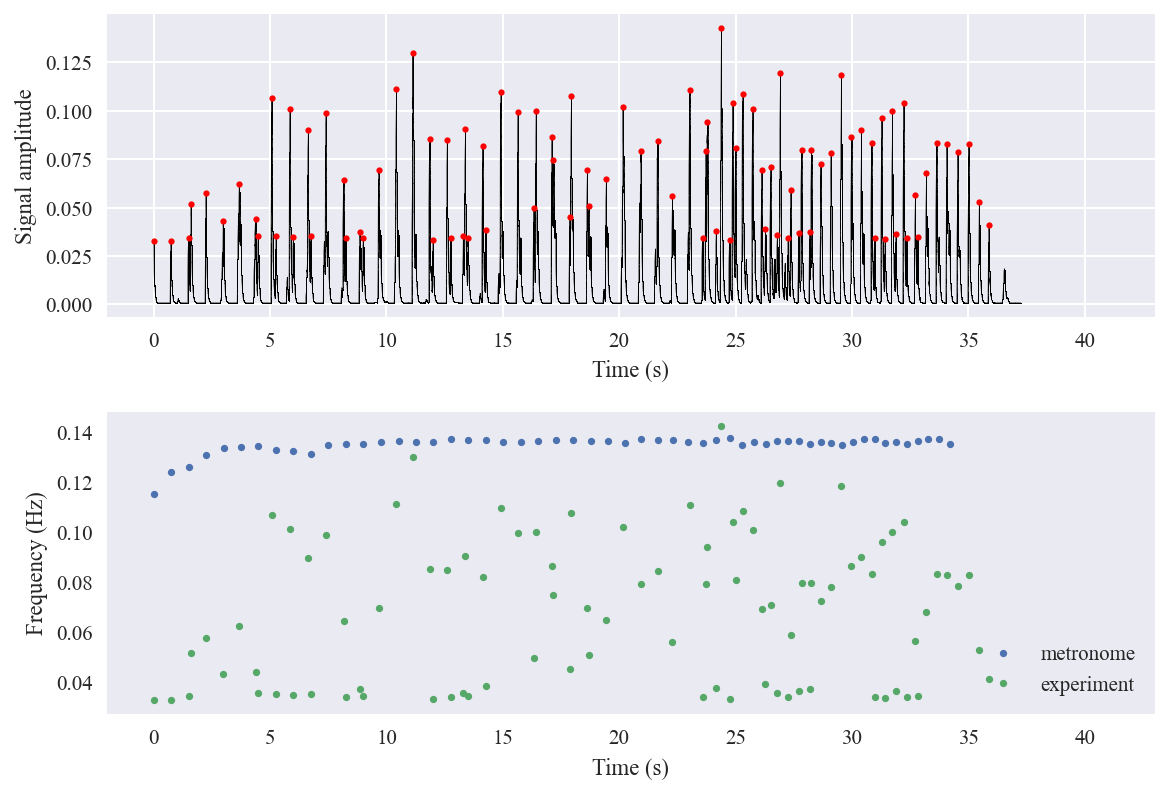

In [28]:
fam_tuple_lm = new_data_extract('lydfiler/Sigrids_familie/low_mid_fam.wav',  
                                resolution=np.int16, 
                                neigh_rm=1000, 
                                height_var=0.025,
                                prominence_var=0.02)
met_tuple_lm = new_data_extract('lydfiler/metronomfiler/low_mid.wav', 
                                resolution = np.int16,
                                neigh_rm=1000, 
                                height_var=0.05,
                                prominence_var=0.02)

zero_cut = 0
# Synchornizing
met_tuple_lm, fam_tuple_lm = synchro(zero_cut, met_tuple_lm, fam_tuple_lm)
t_fam_lm, s_fam_lm, pt_fam_lm, p_fam_lm, ft_fam_lm, f_fam_lm = fam_tuple_lm
t_met_lm, s_met_lm, pt_met_lm, p_met_lm, ft_met_lm, f_met_lm = met_tuple_lm


fig, ax = plt.subplots(2,1, dpi=150)

ax[0].plot(t_fam_lm, 
           s_fam_lm, 
           color='black', 
           ls='-', marker='.', 
           linewidth = 0.2, 
           markersize=0.8, 
           label='Smoothed signal')

ax[0].plot(pt_fam_lm, 
           p_fam_lm, 
           color='red', 
           ls='', 
           marker='o', 
           markersize=3, 
           label='Peaks')


#ax[0].set(xlim=(6.5, 7.5), ylim=(0.05, 0.15))
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].set_xlim(-2,43)

ax[1].plot(pt_met_lm, p_met_lm, '.', label='metronome')
ax[1].plot(pt_fam_lm, p_fam_lm, '.', label='experiment')
ax[1].legend(loc='lower right')
ax[1].set_xlim(-2,43)

ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

fig.tight_layout()


In [29]:

filenames = ['Sigrids_familie/low_mid_fam', 'Sigrids_familie/low_high_fam',
             'Sigrids_familie/mid_low_fam', 'Sigrids_familie/mid_high_fam',
             'Sigrids_familie/high_low_fam', 'Sigrids_familie/high_mid_fam']


met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']



fam_list = []
for i, name in enumerate(filenames):
    synced_data = new_final_data(met_filenames[i], 
                                 name, 
                                 resolution=(np.int16, np.int16), 
                                 neigh_rm=1000, 
                                 height=0.025, 
                                 prominence=0.02)
    
    fam_list.append(synced_data)

low = 80
mid = 130
high = 180

max_beats = 56
threshold_l = 24
threshold_h = 40

# 3x3 bpm matrix
bpm = np.array([[(low, low), (low, mid), (low, high)],
                [(mid, low), (mid, mid), (mid, high)],
                [(high, low), (high, mid), (high, high)]])
# set diag = 0
for i in range(3):
    bpm[i,i] = (0, 0)



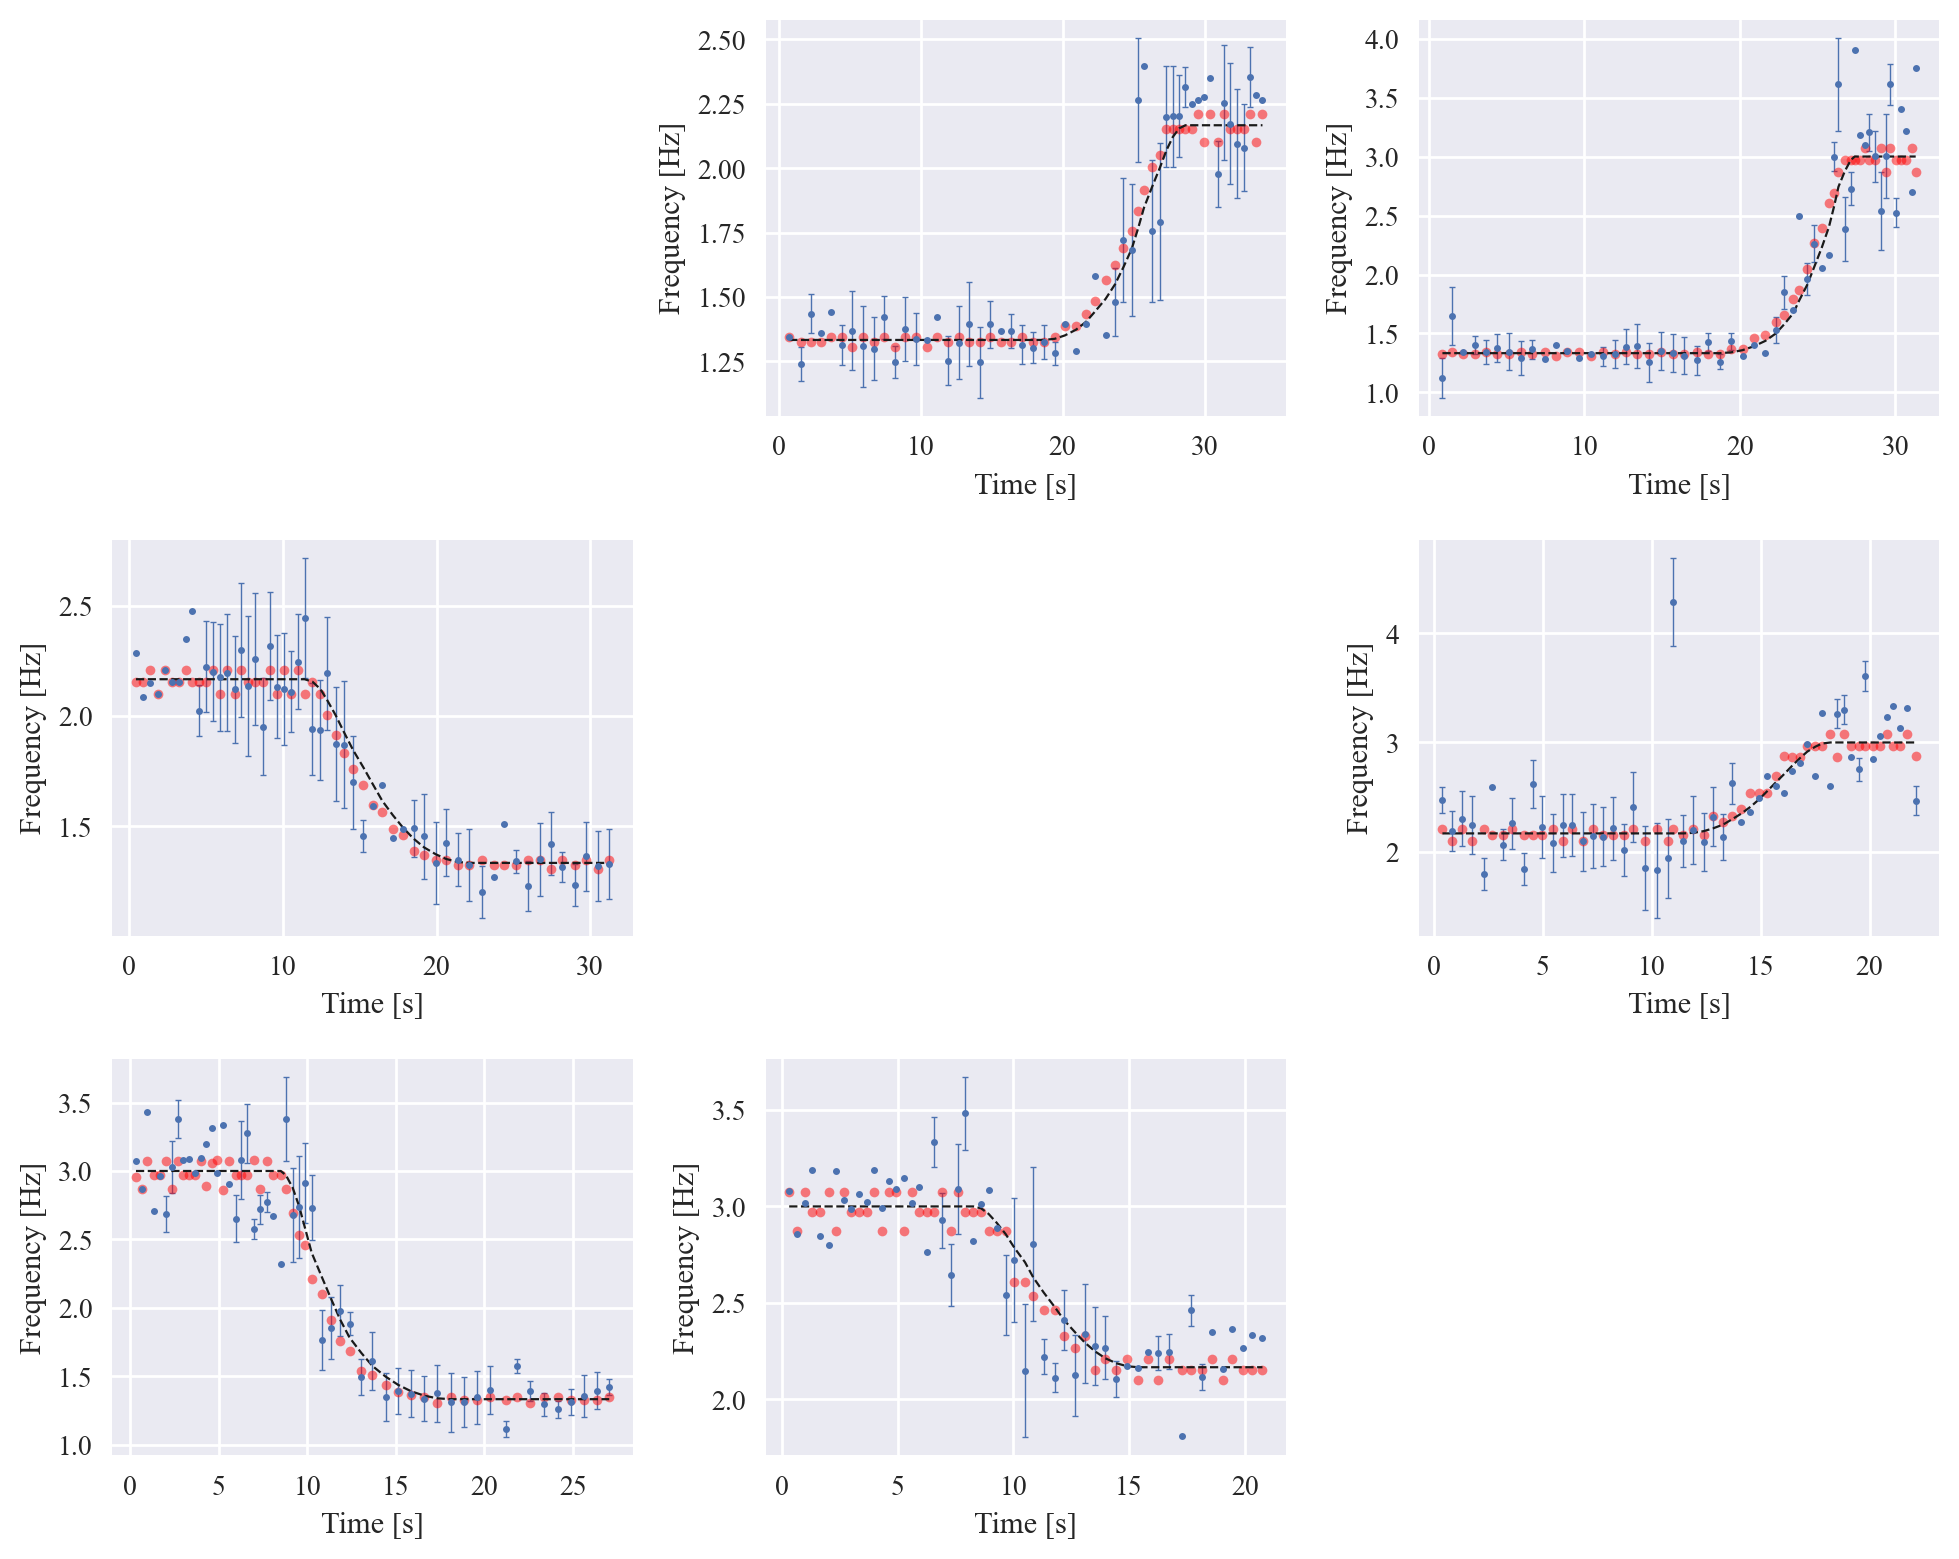

In [30]:
fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)


counter = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if i != j:

            sig_x = np.linspace(0, fam_list[counter][3][-1], len(fam_list[counter][3]))
            p_list = p_func(sig_x, threshold_l, threshold_h)
            sig_y = 1 / interval_calc(*bpm[i,j], p_list)

            ax[i,j].errorbar(fam_list[counter][3], fam_list[counter][0], yerr=fam_list[counter][1], marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
            ax[i,j].plot(fam_list[counter][3], fam_list[counter][2], marker='.', ls='', color='red', alpha=0.5)
            ax[i,j].set(xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
            ax[i,j].plot(fam_list[counter][3], sig_y, ls='--', marker='', linewidth=0.8, color='k', alpha=1)

            counter += 1
        else: 
            ax[i,j].set_visible(False)
        

fig.tight_layout()
plt.show()


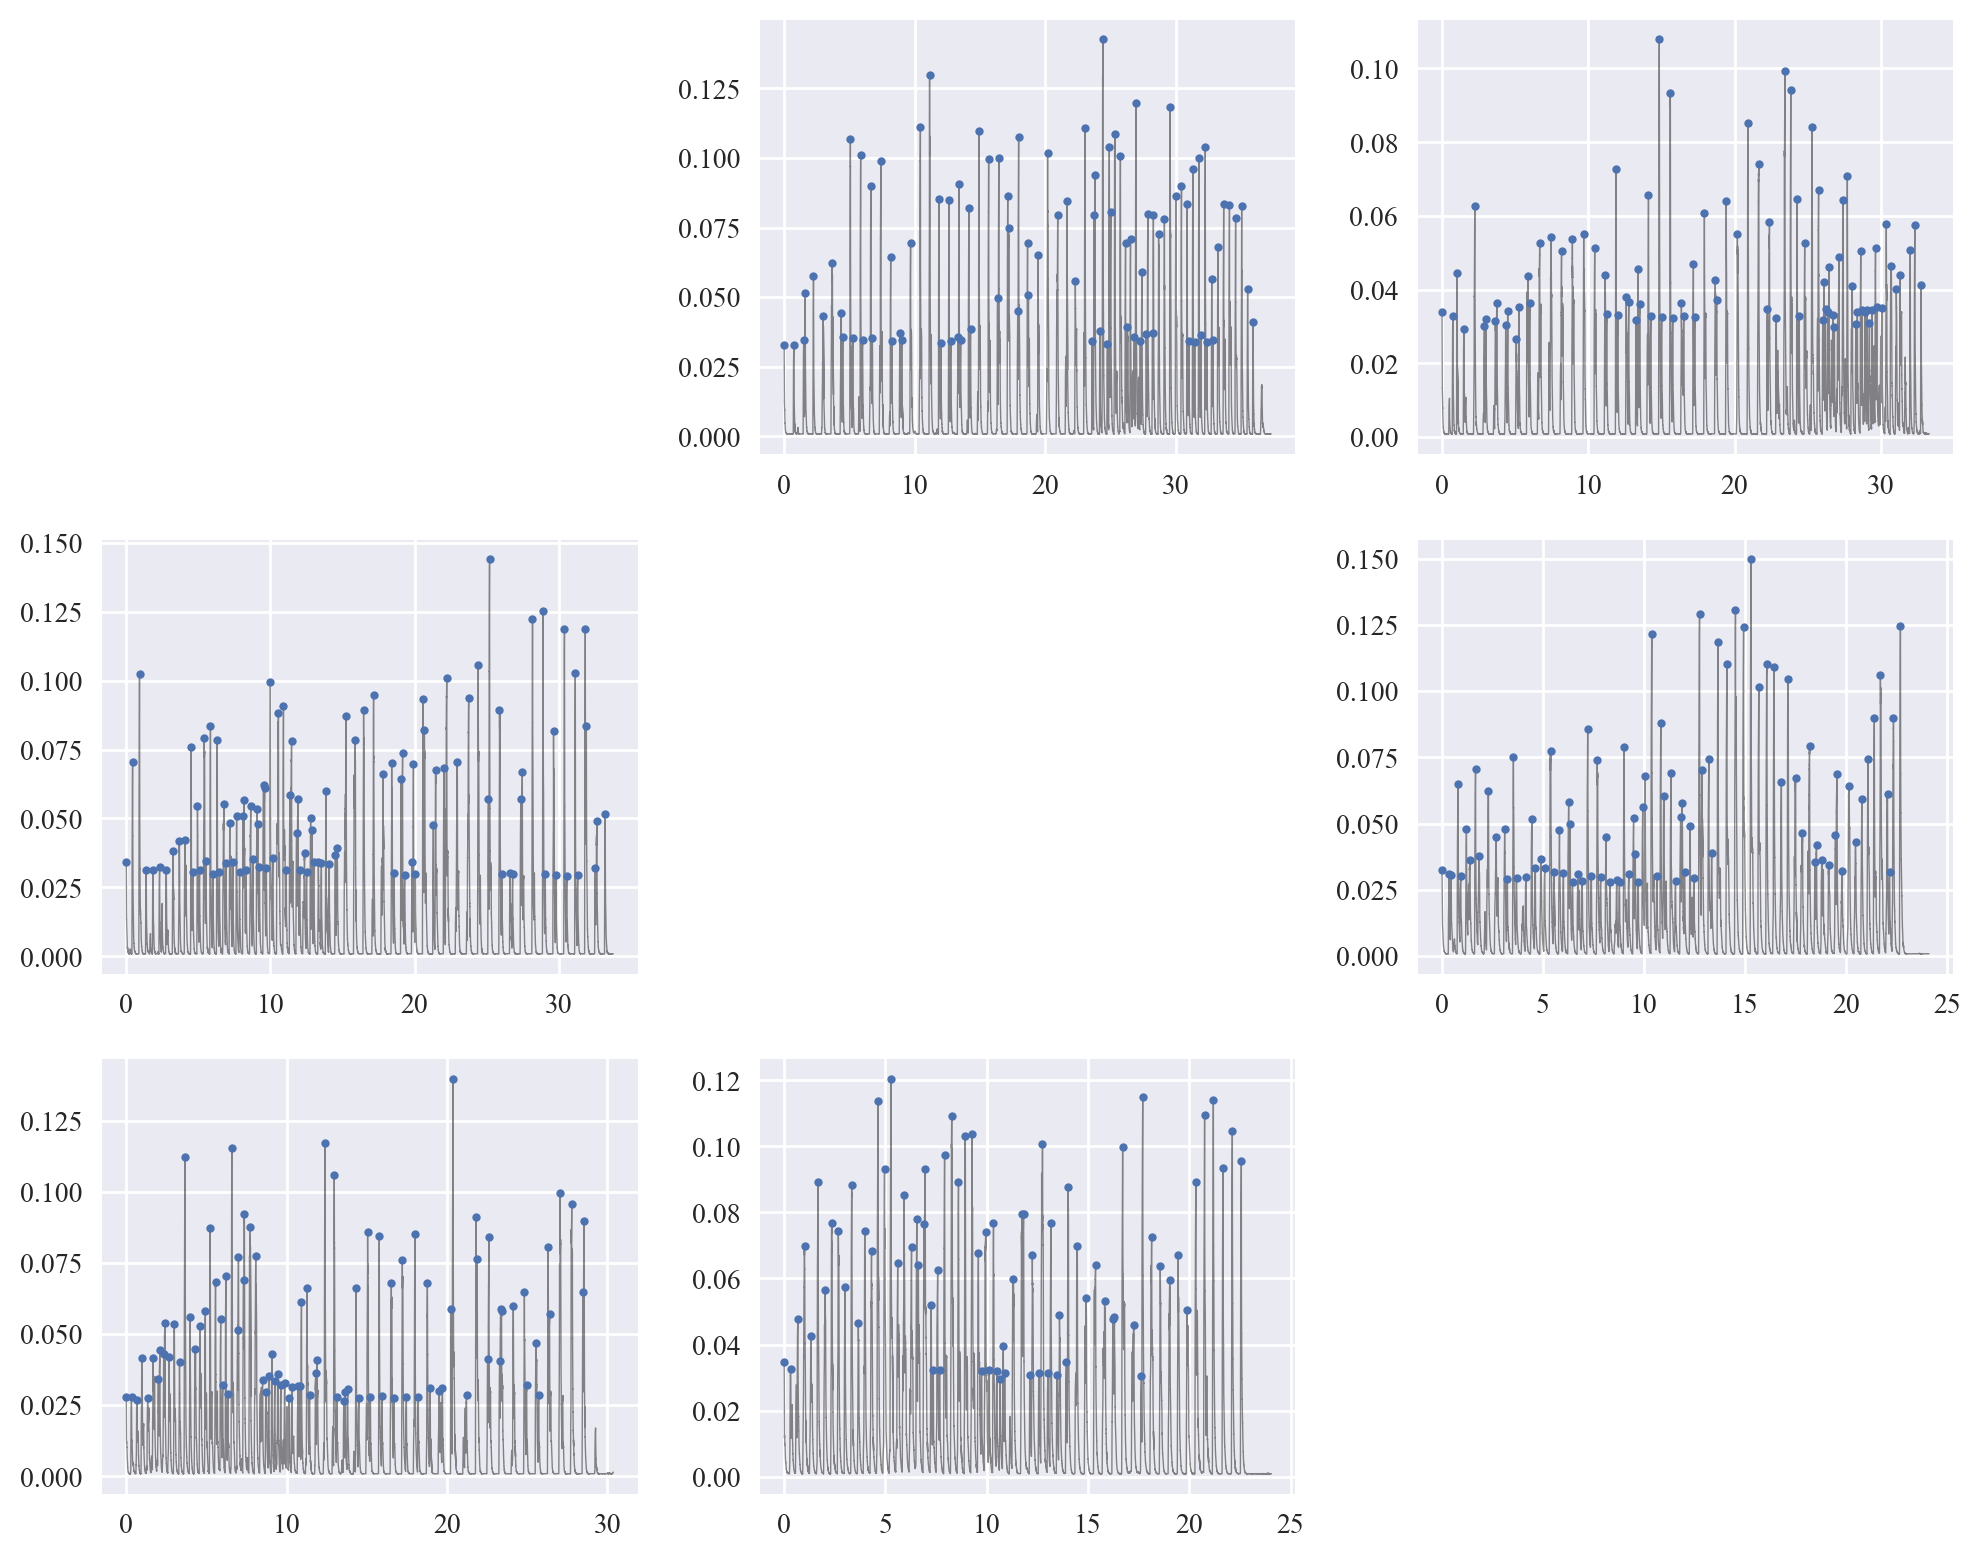

In [31]:
fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
ax = ax.flatten()

counter = 0
for i in range(len(ax)):
    if i % 4 != 0:
    
        ax[i].plot(fam_list[counter][4], fam_list[counter][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
        ax[i].plot(fam_list[counter][6], fam_list[counter][7], marker = 'o', markersize = 3, ls = '')
        #ax[i].set(ylim=(0.8, 5), xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))

        counter += 1
    else: 
        ax[i].set_visible(False)

fig.tight_layout()
plt.show()
